### korean number GAN 모형 keras

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

In [2]:
import pandas as pd

data = pd.read_csv('c:/workspace3/data/images/image_pixels_augmented.csv').astype('float32')
data.head()

,255,255.1,254,253,250,249,251,254.1,251.1,253.1,...,244.14,255.409,252.47,253.76,252.48,255.410,254.131,252.49,255.411,255.412
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,...,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,248.0,255.0,255.0,252.0,252.0,255.0,253.0,255.0,253.0,...,249.0,251.0,255.0,255.0,252.0,253.0,252.0,254.0,253.0,250.0
2,255.0,249.0,253.0,255.0,250.0,250.0,252.0,244.0,255.0,255.0,...,253.0,251.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,255.0


In [3]:
width, height, channel = 32, 32, 1 # 이미지 사이즈 32*32 pixel

X = data.values
X = X.reshape((X.shape[0], width, height, channel))
print(X.shape)

(9962, 32, 32, 1)


In [4]:
# Normalization [0,255] -> [-1,1]

X = (X - 127.5) / 127.5
print(X[0][0][:5])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


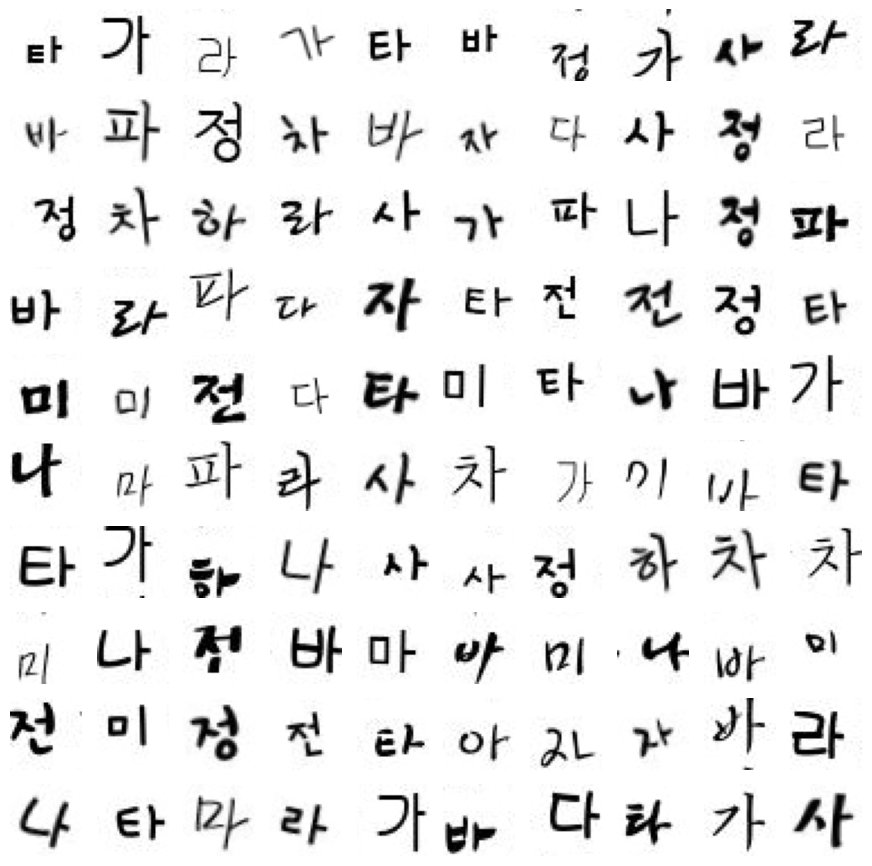

In [5]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(11,11))

i = 1

for image in X:
    plt.subplot(10, 10, i) #(10*10)
    image = image.reshape(width, height)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    i+=1

    if i > 100:
        break

plt.show()

In [6]:
# 학습용 데이터

BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(X.shape[0]).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None)>


In [7]:
# 생성 모형

from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential

def build_generator_model():
    model = Sequential()

    model.add(Dense(1024, input_dim=100))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(8*8*128))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8, 8, 128))) 

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU()) 
    
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    assert model.output_shape == (None, 32, 32, 1)
    
    return model

#       input           output
#       100             32x32

In [8]:
# 생성 모델

generator = build_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8192)              8396800   
                                                                 
 batch_normalization_1 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8192)              0

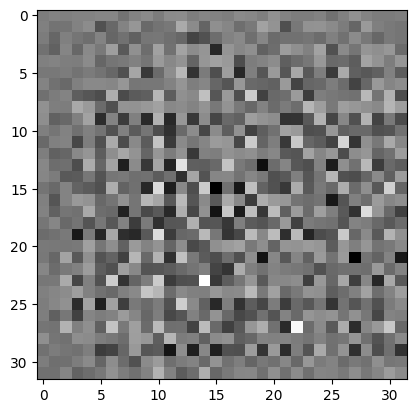

In [9]:
# 학습되지 않은 생성 모델이 만든 이미지

import os    

os.environ['KMP_DUPLICATE_LIB_OK']='True'

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
# 판별 모형

from tensorflow.keras.layers import Conv2D, Dropout, Flatten

def build_discriminator_model():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), strides=2, padding='same', input_shape=[32, 32, 1]))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1))

    return model

#       input           output
#                       1

In [11]:
# 판별 모델 생성

discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [12]:
# 학습되지 않은 판별 모형의 결과

predicted = discriminator(generated_image)
print(predicted)
#   0.0 ~ 1.0
#   가짜  진짜

tf.Tensor([[0.00054037]], shape=(1, 1), dtype=float32)


In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# 최적화함수(생성 모형)
generator_optimizer = Adam(1e-4)

# 최적화함수(판별 모형)
discriminator_optimizer = Adam(1e-4)

#손실함수
cross_entropy = BinaryCrossentropy(from_logits=True)

In [14]:
# 생성 모델의 목표 : 판별 모델이 가짜 이미지를 판별했을 때 판별값이 1에 가까워지도록 하는 것

def generator_loss(fake_output):

    return cross_entropy(tf.ones_like(fake_output), fake_output) # 1과 fake 이미지 비교

In [15]:
def discriminator_loss(real_output, fake_output):
    # 1과 real image 비교(real image의 판별값이 1에 가까워지도록)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # 0과 fake image 비교(fake image의 판별값이 0에 가까워지도록)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

In [16]:
# 학습 파라미터 설정

EPOCHS = 300
noise_dim = 100

In [17]:
# GradientTape() 자동미분 예제

w = tf.Variable(tf.random.normal((3, 2)), name='w') #3행 2열의 난수
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape() as tape: # with 구문 내의 연산 내용 기록
  y = x @ w + b # x@w 행렬곱
  print('y:',y)

  loss = tf.reduce_mean(y**2)

[dl_dw, dl_db] = tape.gradient(loss, [w, b])  
[dl_dw, dl_db]

y: tf.Tensor([[-5.1315475   0.48308337]], shape=(1, 2), dtype=float32)


[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ -5.1315475 ,   0.48308334],
        [-10.263095  ,   0.9661667 ],
        [-15.394642  ,   1.44925   ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-5.1315475 ,  0.48308334], dtype=float32)>]

In [19]:
def train_step(images):
    # 생성 모델 input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #자동 미분
        generated_images = generator(noise, training=True)

        # real image의 판별값
        real_output = discriminator(images, training=True)
#                               진짜 이미지 훈련

        # fake image의 판별값
        fake_output = discriminator(generated_images, training=True)
#                               가짜 이미지 훈련

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
from IPython.display import clear_output
import time

# 노이즈 시각화
test_noise = tf.random.normal([100, noise_dim])

def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5 * images + 0.5

    plt.figure(figsize=(11,11))
  
    i = 1

    for image in images:
        image = image.reshape(width, height)
        plt.subplot(10, 10, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        i+=1

    plt.suptitle(f"EPOCH: {epoch}", fontsize = 25)
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()    

    clear_output(wait=True)

    time.sleep(0.5)        

In [21]:
def train(dataset, epochs):

  for epoch in range(epochs):
    for image_batch in dataset: # mini batch
      train_step(image_batch)
    print("%s epochs trained" % epoch)

    show_generated_images(epoch)

299 epochs trained
4/4 [==============================] - 0s 6ms/step


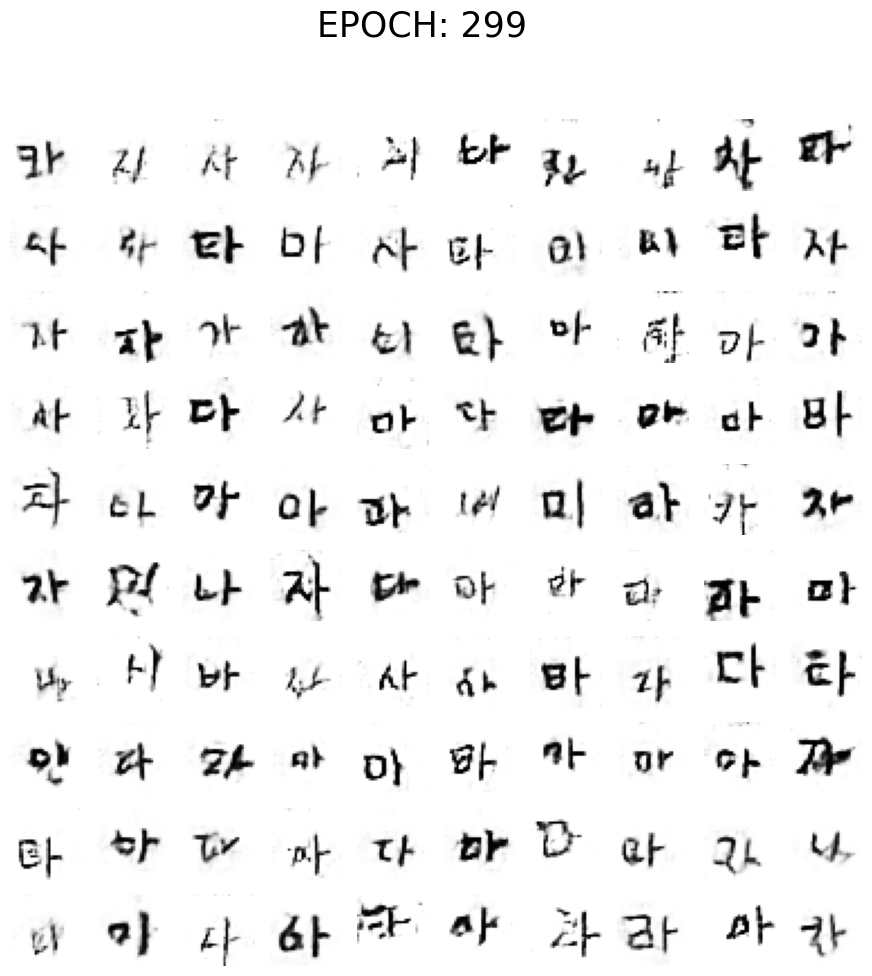

In [22]:
train(train_dataset, EPOCHS)

In [23]:
#학습이 완료된 모형 저장

generator.save('korean_number_gen_test.h5')